In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import time

In [2]:
%store -r data_ready

In [3]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
select_data = data_ready[data_ready['category'].isin(['hep-ph','hep-th','quant-ph'])].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"],
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_ready['clean_text'][:100])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = np.array([len(a) for a in X_train]).max()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

In [7]:
def create_emb_model(embedding_dim=50):
    model = Sequential(name="Neural Network with Embedded Layer")
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# define the grid search parameters
cand_ep = [5, 10, 20][:1] #number of epochs
cand_bs = [1024, 2048, 4096][2:] #batch size
cand_ed = [50, 100, 200][:1] #dimension of output of embedding layer
#OTHER HYPERPARAMETERS TO OPTIMIZE: Type of pooling

model = KerasClassifier(build_fn=create_emb_model, verbose=0)
param_grid = dict(batch_size=cand_bs, epochs=cand_ep, embedding_dim=cand_ed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

In [105]:
s = time.time()
grid_result = grid.fit(X_train, dummy_y_train)
f = time.time()

print(f-s)

In [106]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')
emb_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(emb_cv_results0.columns.values)
emb_cv_results0 = emb_cv_results0[clist[-2:] + clist[:-2]]
%store emb_cv_results0
emb_cv_results0

Best: 0.894905 using {'batch_size': 4096, 'embedding_dim': 50, 'epochs': 5}
Stored 'emb_cv_results0' (DataFrame)


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_embedding_dim,param_epochs
rank_test_score,,,,,,,
1,0.894905,0.036688,120.70791,2.476115,4096,50,5


In [10]:
model = create_emb_model(embedding_dim = 50)
model.summary()

Model: "Neural Network with Embedded Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 193, 50)           92400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
Total params: 92,943
Trainable params: 92,943
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, dummy_y_train, epochs=5, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=4096)

C:\Users\Matteo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/5
27/27 [==============================] - 10s 350ms/step - loss: 1.0890 - accuracy: 0.3750 - val_loss: 1.0529 - val_accuracy: 0.3788
Epoch 2/5
27/27 [==============================] - 8s 312ms/step - loss: 1.0347 - accuracy: 0.4237 - val_loss: 0.9511 - val_accuracy: 0.6043
Epoch 3/5
27/27 [==============================] - 9s 322ms/step - loss: 0.9031 - accuracy: 0.6497 - val_loss: 0.7409 - val_accuracy: 0.8071
Epoch 4/5
27/27 [==============================] - 10s 386ms/step - loss: 0.6854 - accuracy: 0.8379 - val_loss: 0.5228 - val_accuracy: 0.9010
Epoch 5/5
27/27 [==============================] - 11s 387ms/step - loss: 0.4764 - accuracy: 0.9108 - val_loss: 0.3560 - val_accuracy: 0.9258


In [12]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9284
Testing Accuracy:  0.9258


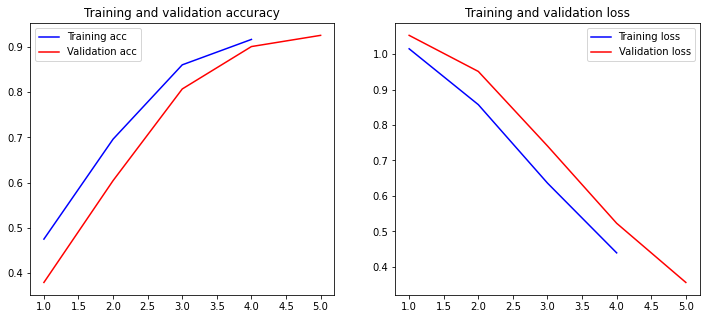

In [15]:
plot_history(history)